In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random
import os, logging, glob
from _dataset import dataset
from _logging import set_logging
from _utility import get_perc, get_dictionaries_from_list
from _pckle import save_pickle_object, load_pickle_object

set_logging(logging)
filename = "cats_dogs_model"
model = load_pickle_object(filename)
filename = "cats_dogs_X_test"
X_test = load_pickle_object(filename)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_folder = "cats_dogs_small"

2023-01-24 20:31:06,262 | INFO : Loading pickle file from: pickle\cats_dogs_model
2023-01-24 20:31:06,624 | INFO : Loading pickle file from: pickle\cats_dogs_X_test


In [2]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size = 1

In [3]:
classes = ["cat", "dog"]
dict_classes, dict_classes_rev = get_dictionaries_from_list(classes)
test_data = dataset(X_test, dict_classes, IMAGE_SIZE, logging)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)

In [20]:
model.eval()
df_check_model_data = pd.DataFrame(columns = ["image_path", "prediction", "gt_label", "pred_label"])
with torch.no_grad():
    for i, (image, label_) in enumerate(test_loader):
        gt_label = label_[0].item()
        image = image.to(device)
        image_path = X_test[i]
        preds = model(image)
        prediction_ = F.softmax(preds, dim = 1)[:, 1]
        prediction = prediction_[0].item()
        pred_label = dict_classes["cat"] if prediction < 0.5 else dict_classes["dog"]
        row = [image_path, prediction, gt_label, pred_label]
        df_check_model_data.loc[len(df_check_model_data.index)] = row


In [22]:
df_check_model_data.head(20)


,image_path,prediction,gt_label,pred_label
0,cats_dogs_small\data\test\cat\cat.1902.jpg,0.381899,0,0
1,cats_dogs_small\data\test\cat\cat.586.jpg,0.212935,0,0
2,cats_dogs_small\data\test\cat\cat.8836.jpg,0.693138,0,1
3,cats_dogs_small\data\test\cat\cat.6324.jpg,0.617875,0,1
4,cats_dogs_small\data\test\cat\cat.7580.jpg,0.326192,0,0
5,cats_dogs_small\data\test\dog\dog.11282.jpg,0.854425,1,1
6,cats_dogs_small\data\test\cat\cat.10758.jpg,0.767932,0,1
7,cats_dogs_small\data\test\dog\dog.11884.jpg,0.716035,1,1
8,cats_dogs_small\data\test\dog\dog.1154.jpg,0.735491,1,1
9,cats_dogs_small\data\test\cat\cat.7052.jpg,0.477536,0,0


In [19]:
df_check_model_data.tail(20)

,image_path,prediction,gt_label,pred_label
119,cats_dogs_small\data\test\dog\dog.7735.jpg,0.680762,1,1
120,cats_dogs_small\data\test\cat\cat.11486.jpg,0.698480,0,1
121,cats_dogs_small\data\test\cat\cat.2334.jpg,0.234668,0,0
122,cats_dogs_small\data\test\cat\cat.6839.jpg,0.207558,0,0
123,cats_dogs_small\data\test\dog\dog.11826.jpg,0.405233,1,0


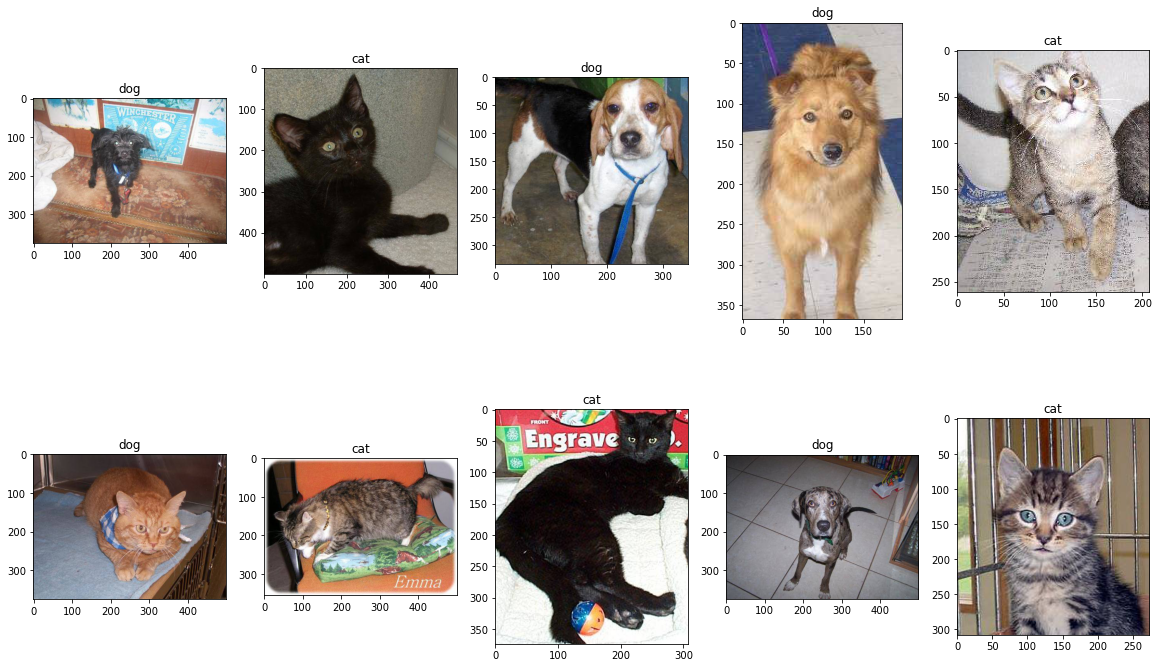

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        break    
    image_path = random.choice(df_check_model_data['image_path'].values)
    
    label = df_check_model_data.loc[df_check_model_data['image_path'] == image_path, 'pred_label'].values[0]
        
    img = Image.open(image_path)
    
    ax.set_title(dict_classes_rev[label])
    ax.imshow(img)


In [25]:
criterion = nn.CrossEntropyLoss()
test_accuracy = 0
test_loss = 0
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)
    
    test_output = model(data)
    loss = criterion(test_output,label)
    
    
    acc = ((test_output.argmax(dim=1) == label).float().mean())
    test_accuracy += acc/ len(test_loader)
    test_loss += loss/ len(test_loader)
    
print(f'test_accuracy : {test_accuracy}, test_loss : {test_loss}')

test_accuracy : 0.7096768617630005, test_loss : 0.5752736926078796
